# Geoprocessing and Exporting Data

## Part 1 - Data Preparation

In this task, let's say we have a client that wants to see all highways in a certain county.  
We have shapefiles for:
- Counties (Sourced from US Census Bureau Tiger Files)
- Highways (Sourced from Caltrans)

An added complication is that the client doesn't have GIS Software.  They'll need to view the spatial data in Google Earth and the tabular data in Microsoft Excel.

In [ ]:
import arcpy

In [ ]:
# Create a new File Geodatabase
gdb = arcpy.management.CreateFileGDB('.','Week_2_Data')

# Verify that the new geodatabase exists.
arcpy.Exists(gdb)

Finding documentation for arcpy functions is very similar to finding documentation on tools in ArcMap or ArcGIS Pro.  Google works pretty well too.

https://pro.arcgis.com/en/pro-app/tool-reference/conversion/feature-class-to-feature-class.htm


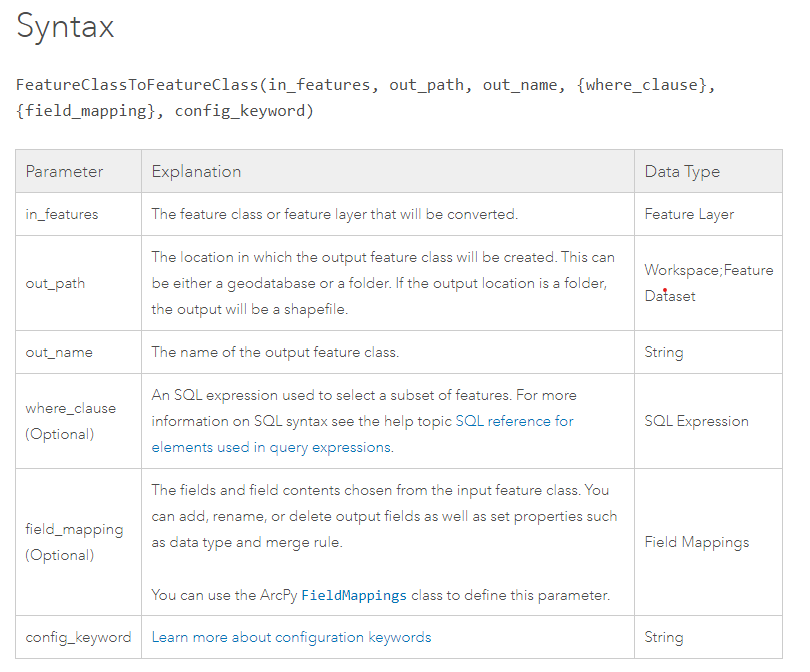



In [ ]:
# copy our highways shapefile into our geodatabase
shp_highways = r".\Caltrans_Highways\Caltrans_Highways.shp"
fc_highways = arcpy.conversion.FeatureClassToFeatureClass(shp_highways, gdb, 'Caltrans_Highways')

In [ ]:
# copy our counties shapefile into our geodatabase
shp_counties = r".\Tiger_Counties\CA_Counties.shp"
fc_counties = arcpy.conversion.FeatureClassToFeatureClass(shp_counties, gdb, 'Counties')

Now we're going to intersect our two layers.  Because we saved the results of our previous operations as variables, we can use those as inputs to our next operation!

https://pro.arcgis.com/en/pro-app/tool-reference/analysis/intersect.htm

In [ ]:
# feature classes we just created
fcs_to_intersect = [fc_counties, fc_highways]

# intersect the two feature classes
fc_intersect = arcpy.analysis.Intersect(fcs_to_intersect, gdb[0]+'//Highways_Intersect')


In [ ]:
# Get the count of the resulting intersect
arcpy.management.GetCount(fc_intersect)

## Bonus: cleaning up the data and fields

We could move on here, but if we're making a product for someone, it would be nice to get rid of the extraneous information that's contained in our intersected feature class.

In [ ]:

# Get all the fields from the intersect FC
fields_intersect = arcpy.ListFields(fc_intersect)

# Make an empty List
fnames_intersect = []

# add field names to the list
for field in fields_intersect:
    fnames_intersect.append(field.name)

fnames_intersect

In [ ]:
# Fields we want to keep in the dataset
fields_to_keep = ['Shape','NAMELSAD','FULLNAME','HWY_NUM','TYPE','Shape_Length','OBJECTID']

# Empty list to hold the fields that we want to delete
fields_to_delete = []

# for each field in the intersected feature class, check if that field is in our "fields to keep" list
# if the field isn't in that list, put it in the "fields to delete" list
for fname in fnames_intersect:
    if fname not in fields_to_keep:
        fields_to_delete.append(fname)

fields_to_delete

Now we'll delete those fields from the feature class

https://pro.arcgis.com/en/pro-app/tool-reference/data-management/delete-field.htm

In [ ]:
arcpy.management.DeleteField(fc_intersect, fields_to_delete)

Now let's change a field name.  This will be useful further down the line...

https://pro.arcgis.com/en/pro-app/tool-reference/data-management/alter-field-properties.htm

In [ ]:
arcpy.management.AlterField(fc_intersect, 'FULLNAME', 'NAME')

## Part 2 - Exporting data for people to use



### Feature layers vs Feature classes (or shapefiles)

When you highlight a dataset in ArcCatalog (or the catalog view in ArcGIS Pro), you're looking at a feature class or shapefile.  Some tools in ArcGIS will accept those datasets as inputs.  Others will not.  In those cases, you'll need to make a _Feature Layer_ object.  This is the python equivalent of adding a dataset to your map in ArcMap or ArcGIS Pro.  

Making a feature layer allows you to do things that you would otherwise only be able to do in a map view, like:
- Table Joins
- Select by Attributes
- Apply symbology

https://pro.arcgis.com/en/pro-app/tool-reference/data-management/make-feature-layer.htm


In [ ]:
#if you skipped Part 1, un-comment and run the following line:

# gdb = r'./Week_2_Data_Z.gdb'

In [ ]:
# make a feature layer.  
flyr = arcpy.management.MakeFeatureLayer(fc_intersect, 'Alameda County',"NAMELSAD = 'Alameda County'")

In [ ]:
arcpy.management.GetCount(flyr)

Now that we have a feature layer, we can do different things with it.  The first thing we'll do is set some symbology.  I've gone ahead and made a dummy symbology layer that we can use.  It's in this directory and called Highways.lyrx.

https://pro.arcgis.com/en/pro-app/tool-reference/data-management/apply-symbology-from-layer.htm

In [ ]:
lyrx = r'./Highways.lyrx'
arcpy.management.ApplySymbologyFromLayer(flyr, lyrx)

Now that we have a layer that's symbolized, we can export that layer to a kmz!

https://pro.arcgis.com/en/pro-app/tool-reference/conversion/layer-to-kml.htm

In [ ]:
arcpy.conversion.LayerToKML(flyr, r'./Alameda County Highways.kmz')

We can also make an excel file!

https://pro.arcgis.com/en/pro-app/tool-reference/conversion/table-to-excel.htm

In [ ]:
arcpy.conversion.TableToExcel(flyr, r'./Alameda County Highways.xls')

## Part 3 - Repeating the work!

Now that we've gone through the data preparation and created a kmz/excel output for someone, let's clean up our code so we can use it again.  You may have noticed that we reused "Alameda County" a lot during Part 2.  That makes that a good candidate for turning into a variable.  Let's look at how we can reuse a string in a bunch of different places.

In [ ]:

county_to_export = "Contra Costa County"

# Option 1 - concatenate strings
query_1 = "NAMELSAD = '"+county_to_export+"'"

# Option 2 - use the string.format() function
query_2 = "NAMELSAD = '{}'".format(county_to_export)

print(query_1)
print(query_2)

In [ ]:

# copied the code above but replaced parameters with variables
flyr = arcpy.management.MakeFeatureLayer(fc_intersect, county_to_export, query_2)

arcpy.management.ApplySymbologyFromLayer(flyr, lyrx)

# add our county_to_export variable to the outputs
arcpy.conversion.LayerToKML(flyr, r'./{} Highways.kmz'.format(county_to_export))
arcpy.conversion.TableToExcel(flyr, r'./{} Highways.xls'.format(county_to_export))


Now let's turn this into a tool with an input

In [ ]:
# the input() function is built into python.  
# It asks the user to input something and returns the input as a string

county_to_export = input('Which County? ')
query_2 = "NAMELSAD = '{}'".format(county_to_export)
flyr = arcpy.management.MakeFeatureLayer(fc_intersect, county_to_export, query_2)

arcpy.management.ApplySymbologyFromLayer(flyr, lyrx)

arcpy.conversion.LayerToKML(flyr, r'./{} Highways.kmz'.format(county_to_export))
arcpy.conversion.TableToExcel(flyr, r'./{} Highways.xls'.format(county_to_export))

## Part 4 - Build a function and repeat it!

In [ ]:
county_to_export = input('Which County? ')

# let's make a new folder
new_folder = arcpy.management.CreateFolder('.', county_to_export)
query_2 = "NAMELSAD = '{}'".format(county_to_export)
lyrx = r'./Highways.lyrx'
flyr = arcpy.management.MakeFeatureLayer(fc_intersect, county_to_export, query_2)

arcpy.management.ApplySymbologyFromLayer(flyr, lyrx)

# we can modify our path out to use the new folder we made
arcpy.conversion.LayerToKML(flyr, r'./{}/{} Highways.kmz'.format(county_to_export, county_to_export))
arcpy.conversion.TableToExcel(flyr, r'./{}/{} Highways.xls'.format(county_to_export, county_to_export))
print('done')

In [ ]:
all_counties = [row[0] for row in arcpy.da.SearchCursor(fc_intersect, 'NAMELSAD')]
list(set(all_counties))